Copyright © 2021, SAS Institute Inc., Cary, NC, USA.  All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

## Using the `TSP` Action in the `OPTNETWORK` Actionset To Find the Shortest Tour Between the US Busiest Airports

------------------------------------------------------------------------------------------------------------------------------

In this Jupyter notebook, we provide an application of the Travel Salesman Problem to find the shortest tour that visits 60 busiest US airports. 
We start by building a network of major US airports as the nodes and the existing air routes between airports as our directed links. The required datasets, including airports, airlines, and routes, are obtained from the "openflights.org" website. 
A feasible tour is a cycle visiting every vertex exactly once, and it is called a Hamiltonian cycle. Note that determining whether or not such a tour exists is an NP-hard problem. 
The code for reading the data as well as the data preparation and cleaning steps, are stored in the "helper.py" script. 

To read more about the `TSP` algorithm, refer to [SAS Documentation](https://pubshelpcenter.unx.sas.com/test/doc/en/pgmsascdc/default/casactnopt/cas-optnetwork-tsp.htm?fromDefault=).  

------------------------------------------------------------------------------------------------------------------------------
The flow of this notebook is as follows:
* [Reading the airports, airlines, and routes data from openflights website](#1st-bullet)
* [Connecting to CAS server](#2nd-bullet)
* [Uploading links (routes)](#3rd-bullet)
* [Calling the `TSP` action](#7th-bullet)
* [Visualizing the result](#8th-bullet)

------------------------------------------------------------------------------------------------------------------------------
**Prepared by:** Hossein Tohidi (<i class="fa fa-github" aria-hidden="true"></i> [Hossein-Tohidi](https://github.com/Hossein-Tohidi))


In [1]:
import swat
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
%matplotlib notebook  
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()),r"../../common/python"))
import cas_connection as cas 
import helper
import warnings
warnings.filterwarnings("ignore",category=FutureWarning) 

### Reading the airports, airlines, and routes data from openflights website <a class="anchor" id="1st-bullet"></a>

In [2]:
airports = helper.read_airports("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat")
airports.head()

,AirportID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz,Type,Source,node,pos
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports,GKA,"(145.391998291, -6.081689834590001)"
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports,MAG,"(145.789001465, -5.20707988739)"
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports,HGU,"(144.29600524902344, -5.826789855957031)"
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports,LAE,"(146.725977, -6.569803)"
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports,POM,"(147.22000122070312, -9.44338035583496)"


### Find Optimal Tour to Visit US Busiest Airports

In [3]:
major_airports = ['ABQ', 'ATL', 'AUS', 'BDL', 'BNA', 'BOI', 'BOS', 'BUR', 'BWI', 'CHS',
                  'CLE', 'CLT', 'CMH', 'CVG', 'DAL', 'DCA', 'DEN', 'DFW', 'DTW', 'EWR',
                  'FLL', 'HOU', 'IAD', 'IAH', 'IND', 'JAX', 'JFK', 'LAS', 'LAX', 'LGA',
                  'MCI', 'MCO', 'MDW', 'MEM', 'MIA', 'MKE', 'MSP', 'MSY', 'OAK', 'OMA',
                  'ONT', 'ORD', 'PBI', 'PDX', 'PHL', 'PHX', 'PIT', 'RDU', 'RNO', 'RSW',
                  'SAN', 'SAT', 'SEA', 'SFO', 'SJC', 'SLC', 'SMF', 'SNA', 'STL', 'TPA']
airports = airports[airports['IATA'].isin(major_airports)].reset_index(drop=True)
airports.head()

,AirportID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz,Type,Source,node,pos
0,3448,General Edward Lawrence Logan International Ai...,Boston,United States,BOS,KBOS,42.364300,-71.005203,20,-5,A,America/New_York,airport,OurAirports,BOS,"(-71.00520325, 42.36429977)"
1,3453,Metropolitan Oakland International Airport,Oakland,United States,OAK,KOAK,37.721298,-122.221001,9,-8,A,America/Los_Angeles,airport,OurAirports,OAK,"(-122.221001, 37.721298)"
2,3454,Eppley Airfield,Omaha,United States,OMA,KOMA,41.303200,-95.894096,984,-6,A,America/Chicago,airport,OurAirports,OMA,"(-95.894096, 41.3032)"
3,3458,Kansas City International Airport,Kansas City,United States,MCI,KMCI,39.297600,-94.713898,1026,-6,A,America/Chicago,airport,OurAirports,MCI,"(-94.713898, 39.2976)"
4,3462,Phoenix Sky Harbor International Airport,Phoenix,United States,PHX,KPHX,33.434299,-112.012001,1135,-7,N,America/Phoenix,airport,OurAirports,PHX,"(-112.01200103759766, 33.43429946899414)"


In [4]:
airlines = helper.read_airlines("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airlines.dat")
airlines.head()

,Airline ID,Airline Name,Alias,Airline IATA,ICAO,Callsign,Airline Country,Active
1,1,Private flight,\N,-,NaN,NaN,NaN,Y
3,3,1Time Airline,\N,1T,RNX,NEXTIME,South Africa,Y
10,10,40-Mile Air,\N,Q5,MLA,MILE-AIR,United States,Y
13,13,Ansett Australia,\N,AN,AAA,ANSETT,Australia,Y
14,14,Abacus International,\N,1B,NaN,NaN,Singapore,Y


In [5]:
routes = helper.read_routes("https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat",airports,airlines)
# only routes from/to major airports
routes = routes[(routes['from'].isin(major_airports))&(routes['to'].isin(major_airports))]
# let's remove multiple links in routes and drop unneccessary columns
routes = routes[['from','to']].drop_duplicates(keep='first')
routes.head()

,from,to
0,FLL,MCO
1,FLL,TPA
2,JAX,TPA
3,MCO,FLL
4,MCO,RSW


In [6]:
# join airports Longitude-Latitude to route
routes = routes.merge(airports[['IATA','Longitude','Latitude']], how='left', left_on='from',right_on='IATA').drop('IATA',axis=1)
routes.rename(columns = {'Longitude':'fromLon','Latitude':'fromLat'},inplace=True)
routes = routes.merge(airports[['IATA','Longitude','Latitude']], how='left', left_on='to',right_on='IATA').drop('IATA',axis=1)
routes.rename(columns = {'Longitude':'toLon','Latitude':'toLat'},inplace=True)
routes.head()

,from,to,fromLon,fromLat,toLon,toLat
0,FLL,MCO,-80.152702,26.072599,-81.308998,28.429399
1,FLL,TPA,-80.152702,26.072599,-82.533203,27.975500
2,JAX,TPA,-81.687897,30.494101,-82.533203,27.975500
3,MCO,FLL,-81.308998,28.429399,-80.152702,26.072599
4,MCO,RSW,-81.308998,28.429399,-81.755203,26.536200


In [7]:
# calculate distance for each edge
routes['weight'] = routes.apply(lambda x:
                                helper.find_great_circle_distance(x["fromLon"],x["fromLat"],x["toLon"],x["toLat"]), axis=1)
routes.head()

,from,to,fromLon,fromLat,toLon,toLat,weight
0,FLL,MCO,-80.152702,26.072599,-81.308998,28.429399,285.991147
1,FLL,TPA,-80.152702,26.072599,-82.533203,27.975500,316.898801
2,JAX,TPA,-81.687897,30.494101,-82.533203,27.975500,291.907495
3,MCO,FLL,-81.308998,28.429399,-80.152702,26.072599,285.991147
4,MCO,RSW,-81.308998,28.429399,-81.755203,26.536200,215.133498


### Connecting to CAS server <a class="anchor" id="2nd-bullet"></a>

In [8]:
s = cas.reconnect()
s.loadActionSet('optnetwork')

NOTE: Added action set 'network'.
NOTE: Added action set 'optnetwork'.


[actionset]

 'optnetwork'

+ Elapsed: 0.0021s, user: 0.00106s, sys: 0.00103s, mem: 0.221mb

### Uploading links (routes)  <a class="anchor" id="3rd-bullet"></a>

In [9]:
s.upload(routes, casout = {'name':'RouteLinks', 'replace':True})

NOTE: Cloud Analytic Services made the uploaded file available as table ROUTELINKS in caslib CASUSER(hotohi).
NOTE: The table ROUTELINKS has been created in caslib CASUSER(hotohi) from binary data uploaded to Cloud Analytic Services.


[caslib]

 'CASUSER(hotohi)'

[tableName]

 'ROUTELINKS'

[casTable]

 CASTable('ROUTELINKS', caslib='CASUSER(hotohi)')

+ Elapsed: 0.12s, user: 0.00683s, sys: 0.0049s, mem: 33.5mb

### Calling the `TSP` action and check the status <a class="anchor" id="4th-bullet"></a>

In [10]:
result = s.optNetwork.tsp(
            links       = {"name":"RouteLinks"},
            direction   = 'directed',
            out         = {"name":"TSPTour", "replace":True})

NOTE: The number of nodes in the input graph is 60.
NOTE: The number of links in the input graph is 2134.
NOTE: The TSP solver is starting using an augmented symmetric graph with 120 nodes and 2194 links.
NOTE: Processing the traveling salesman problem using 1 threads across 1 machines.
NOTE: The initial TSP heuristics found a tour with cost 31720.648582 using 0.03 (cpu: 0.02) seconds.
NOTE: The MILP presolver value NONE is applied.
NOTE: The MILP solver is called.
NOTE: The Branch and Cut algorithm is used.
NOTE: The MILP solver added 26 cuts with 2126 cut coefficients at the root.
NOTE: Optimal.
NOTE: Objective = 25278.638868.
NOTE: Processing the traveling salesman problem used 0.12 (cpu: 0.11) seconds.


In [11]:
tour_df =s.CASTable('TSPTour').to_frame()
tour_df.head()

,tsp_order,from,to,weight
0,0.0,ABQ,PHX,527.877675
1,1.0,PHX,SAN,488.768924
2,2.0,SAN,LAX,175.756439
3,3.0,LAX,SJC,495.885628
4,4.0,SJC,BUR,476.850625


In [12]:
airports_merged = airports.merge(tour_df[['from','tsp_order']],how='left',left_on='IATA',right_on='from').drop('from',axis=1)
airports_merged = airports_merged[['node','tsp_order','Name','IATA','City','Country','Latitude','Longitude']].sort_values('tsp_order')
airports_merged.head()

,node,tsp_order,Name,IATA,City,Country,Latitude,Longitude
59,ABQ,0.0,Albuquerque International Sunport,ABQ,Albuquerque,United States,35.040199,-106.609001
4,PHX,1.0,Phoenix Sky Harbor International Airport,PHX,Phoenix,United States,33.434299,-112.012001
38,SAN,2.0,San Diego International Airport,SAN,San Diego,United States,32.733601,-117.190002
7,LAX,3.0,Los Angeles International Airport,LAX,Los Angeles,United States,33.942501,-118.407997
41,SJC,4.0,Norman Y. Mineta San Jose International Airport,SJC,San Jose,United States,37.362598,-121.929001


### Visualizing the result <a class="anchor" id="8th-bullet"></a>

<IPython.core.display.Javascript object>


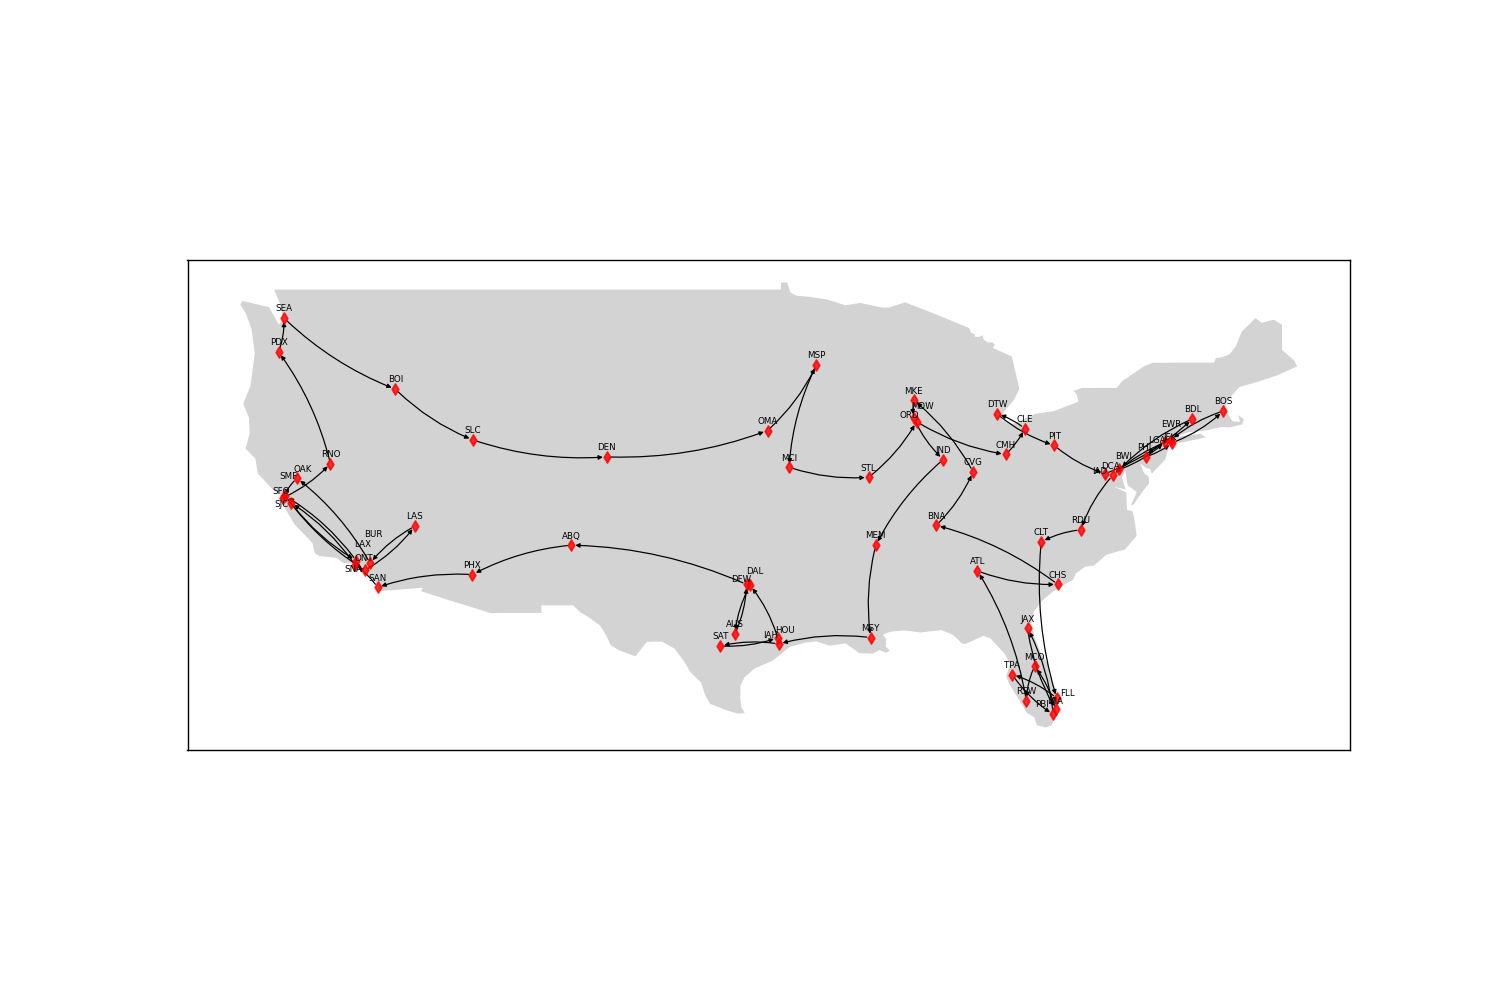

In [13]:
helper.plot_tour(tour_df,airports_merged)